<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#With-smaller-data-set" data-toc-modified-id="With-smaller-data-set-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>With smaller data set</a></span></li><li><span><a href="#With-all-data" data-toc-modified-id="With-all-data-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>With all data</a></span></li></ul></li><li><span><a href="#Support-Vector-Machine" data-toc-modified-id="Support-Vector-Machine-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Support Vector Machine</a></span><ul class="toc-item"><li><span><a href="#Linear-SVM" data-toc-modified-id="Linear-SVM-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Linear SVM</a></span><ul class="toc-item"><li><span><a href="#With-smaller-data-set" data-toc-modified-id="With-smaller-data-set-2.3.1.1"><span class="toc-item-num">2.3.1.1&nbsp;&nbsp;</span>With smaller data set</a></span></li><li><span><a href="#With-whole-data-set" data-toc-modified-id="With-whole-data-set-2.3.1.2"><span class="toc-item-num">2.3.1.2&nbsp;&nbsp;</span>With whole data set</a></span></li></ul></li><li><span><a href="#SVM-with-RBF-Kernel" data-toc-modified-id="SVM-with-RBF-Kernel-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>SVM with RBF-Kernel</a></span></li><li><span><a href="#SVM-with-polynomial-kernel" data-toc-modified-id="SVM-with-polynomial-kernel-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>SVM with polynomial kernel</a></span></li></ul></li></ul></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance comparison</a></span></li></ul></div>

In [2]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    GridSearchCV, ShuffleSplit

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 


# Adjust number of CPU cores to use
n_jobs=2

## Preprocessing

In [21]:
# Load original data
with open('data_processed/all_data.pickle', 'rb') as pickled_file: 
    all_data = pickle.load(pickled_file) 
    
    
# Find categorical variables with more than 50 unique values and drop them
unique_values_cat = all_data.select_dtypes(include='object') \
                        .nunique() \
                        .sort_values(ascending=False) 
# Drop categorical variables with more than 50 categories
all_data = all_data.drop(unique_values_cat[unique_values_cat > 50].index,
                 axis='columns')


def split_preprocess(X=all_data.drop('default', axis='columns'),
                     y=all_data.default,
                     train_size=.8, test_size=.2):
    """
    Splits the data into training and test set of specified size, 
    then applies preprocessing.
    """
    
    # Train-test split 
    # ================
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y,
                         train_size=train_size, test_size=test_size,
                         random_state=1, shuffle=True, stratify=y) 

    pdb.set_trace()
    # Preprocessing
    # =============
    # Imputation and standardization for numeric features
    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    numeric_transformer = Pipeline(steps =[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())]) 

    # Imputation and one-hot encoding for categorical features
    categorical_features = X_train.select_dtypes(include=[object]).columns
    categorical_transformer = Pipeline(steps =[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combining preprocessing for both kinds of features
    # (Features of other dtypes – in our case, boolean – will be
    # appended at the end without transformation.)
    # (Use only 1 core to avoid joblib error)
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric_transformer', 
                 numeric_transformer, numeric_features),
            ('categorical_transformer', 
                 categorical_transformer, categorical_features)],
        remainder='passthrough', n_jobs=1) 
    
    # Print dtypes of untransformed data
    print('data types of columns that were not transformed:\n {}'
            .format(X_train.select_dtypes(exclude=[np.number, object]) \
                    .dtypes.unique()))

    # Apply preprocessing
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)
   

    # Get feature names
    # =================
    # Names of categorical variables after one-hot encoding
    categorical_names = preprocessor \
        .named_transformers_['categorical_transformer'] \
        .named_steps['onehot'] \
        .get_feature_names()
    # Names of columns with other dtype (should only be Boolean)
    other_names = X_train \
        .select_dtypes(exclude=[np.number, object]) \
        .columns
    # Concatenate feature names (Note that list with names of 
    # numeric features was already created above)
    feature_names = list(numeric_features) + \
        list(categorical_names) + list(other_names) 

    
    # Return results
    # ==============
    return(X_train_p, X_test_p, y_train, y_test, feature_names)
  
    
# Create smaller training and test data to start out with
X_train_small, X_test_small, y_train_small, y_test_small, feature_names_small= \
    split_preprocess(train_size=20000, test_size=10000)

# Create full training and test set
X_train, X_test, y_train, y_test, feature_names = \
    split_preprocess(train_size=.8, test_size=.2)


# Save preprocessed training and test sets
filenames_whole = ['X_train', 'X_test', 'y_train', 'y_test']
filenames_small = [filename + '_small' for filename in filenames]
filenames = filenames_whole + filenames_small
files = [X_train, X_test, y_train, y_test,
         X_train_small, X_test_small, y_train_small, y_test_small]

for file, filename in zip(files, filenames):
    joblib.dump(file,
                'data_processed/{}.joblib'.format(filename))
# Delete temporary list to conserve memory
del files

# Save feature names
joblib.dump(feature_names, 'data_procesesd/feature_names')
joblib.dump(feature_names_small, 'data_processed/feature_names_small')

> <ipython-input-21-e60910363dbf>(31)split_preprocess()
-> numeric_features = X_train.select_dtypes(include=[np.number]).columns
(Pdb) X_train.shape
(20000, 86)
(Pdb) q


BdbQuit: 

In [3]:
# Load preprocessed training and test set, incl. feature names 
X_train = joblib.load('data_processed/X_train.joblib')
X_test = joblib.load('data_processed/X_test.joblib')
y_train = joblib.load('data_processed/y_train.joblib')
y_test = joblib.load('data_processed/y_test.joblib')
X_train_small = joblib.load('data_processed/X_train_small.joblib')
X_test_small = joblib.load('data_processed/X_test_small.joblib')
y_train_small = joblib.load('data_processed/y_train_small.joblib')
y_test_small = joblib.load('data_processed/y_test_small.joblib')
feature_names = joblib.load('data_processed/feature_names')
feature_names_small = joblib.load('data_processed/feature_names_small')

## Predictive models

In [4]:
# Dictionaries to store results for SMALL data set
average_precision_1 = {}
classification_reports_1 = {}
most_important_features_1 = {} 
# Note that models with small data were estimated on a different subset
# of the observations, though the size stayed constant.  So don't use future 
# importance on these data, unless re-estimating models!

# Dictionaries to store results for WHOLE data set
average_precision_2 = {}
classification_reports_2 = {}
most_important_features_2 = {}

### Random Forests

In [ ]:
rf = RandomForestClassifier(n_estimators=100, 
        oob_score=False, n_jobs=n_jobs, random_state=1,
        class_weight='balanced_subsample')
rf.fit(X_train_p, y_train)

# Predictions of class and probability
y_pred_rf = rf.predict(X_test_p) 
y_pred_proba_rf = rf.predict_proba(X_test_p)[:, 1]

# Save results
average_precision['random forests'] = \
    average_precision_score(y_test, y_pred_proba_rf)
classification_reports['random forests'] = \
    classification_report(y_test, y_pred_rf)

# Compute feature importance and sort
most_important_features['random forests'] = \
    pd.Series(rf.feature_importances_, index=feature_names) \
            .sort_values(ascending=False) \
            .iloc[: 10]

### Logistic regression
#### With smaller data set

In [22]:
# Logistic regression (Elastic Net) 
# --------------------------------
lr_1 = SGDClassifier(loss='log', penalty='elasticnet', 
                      class_weight='balanced', 
                      max_iter=1000, tol=1E-3, # those are defaults for sklearn 0.21+
                      random_state=1, n_jobs=n_jobs) 

# Parameters to search over
param_grid = {'l1_ratio': np.linspace(0, 1, 11),
              'alpha': np.logspace(-6, 1, 8)}
# Grid search
lr_gs_1 = GridSearchCV(lr_1, param_grid=param_grid, 
                       scoring='average_precision',
                       return_train_score=True,
                       n_jobs=n_jobs, cv=3)
lr_gs_1.fit(X_train_small, y_train_small) 

# Save model
joblib.dump(lr_gs_1, 'saved_models/lr_gs_1.joblib')

['saved_models/lr_gs_1.joblib']

In [27]:
# Load model
lr_gs_1 = joblib.load('saved_models/lr_gs_1.joblib')

In [28]:
# Grid search results for iid = True for best parameters
def gs_best_result(gridsearchcv, decimals=3):
    """Returns details for best results from grid search."""

    # Get mean validation scores
    scores = pd.DataFrame(gridsearchcv.cv_results_) \
                .drop('params', axis='columns')
    
    # Get values for hyperparameters 
    params = pd.DataFrame(
        gridsearchcv.cv_results_['params'])
    
    # Concatenate validation scores and hyperparameters 
    scores_w_params = pd.concat([params, scores], axis=1)
    # Set hyperparameters as index
    scores_w_params = scores_w_params \
                        .set_index(params.columns.tolist())
    
    # Get tuple with best hyperparameters values, making sure it 
    # has the same order as the multi-index.
    best_param_tuple = (
        gridsearchcv.best_params_[scores_w_params.index.names[0]],
        gridsearchcv.best_params_[scores_w_params.index.names[1]])
    
    # Filter results for best hyperparameters 
    best_result = pd.to_numeric(
                    scores_w_params.loc[best_param_tuple, :])
    
    # Return rounded result (convert to dataframe for pretty  printing)
    return(pd.DataFrame(best_result) \
               .round(decimals))

gs_best_result(lr_gs_1)

,0.01
,0.2
mean_fit_time,0.337
std_fit_time,0.067
mean_score_time,0.006
std_score_time,0.001
param_alpha,0.010
param_l1_ratio,0.200
split0_test_score,0.380
split1_test_score,0.394
split2_test_score,0.378


Best score: 0.384, best hyperparameters:  {'alpha': 0.01, 'l1_ratio': 0.2}


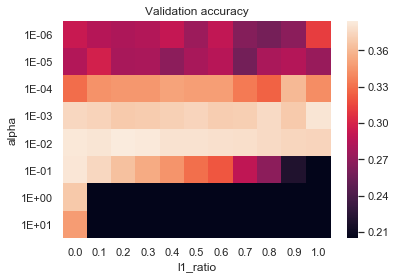

In [29]:
# Predictions
y_pred_lr_1= lr_gs_1.predict(X_test_small)    
y_pred_proba_lr_1= lr_gs_1.predict_proba(X_test_small)[:, 1]

# Save results
average_precision_1['logistic regression'] = \
    average_precision_score(y_test_small, y_pred_proba_lr_1)
classification_reports_1['logistic regression'] = \
    classification_report(y_test_small, y_pred_lr_1)

# Compute feature importance and sort
most_important_features_1['logistic regression'] = \
    pd.Series(lr_gs_1.best_estimator_.coef_[0], 
          index=feature_names_small) \
    .sort_values(ascending=False) \
    .iloc[: 10] 

# Visualize grid search results
def gs_heatmap(gridsearchcv, x_digits=0, y_digits=0,
               x_scientific_notation=True, y_scientific_notation=True):
    """Visualizes validation accuracy from grid search over two hyperparameters."""
    
    # Print test score and  hyperparameters
    print('Best score: {:.3f}, best hyperparameters: '
                .format(gridsearchcv.best_score_), 
          gridsearchcv.best_params_)
      
    # Get mean validation scores
    scores = pd.DataFrame(
        gridsearchcv.cv_results_['mean_test_score'])
    # Get values for hyperparameters
    params = pd.DataFrame(
        gridsearchcv.cv_results_['params'])
    # Concatenate validation scores and hyperparameters 
    scores_w_params = pd.concat([params, scores], 
                                  axis=1)
    # Set first two columns, which correspond to parameters, as index.
    # Then unstack.
    index_cols = list(scores_w_params.columns)[:2]
    scores_2d = scores_w_params.set_index(index_cols) \
                    .squeeze() \
                    .unstack()
    
    # Create desired formatting string for axes (scientific notation and digits)
    if x_scientific_notation == True:
        x_notation = 'E' 
    else: 
        x_notation = 'F'
    x_formatting = '{:.' + str(x_digits) + x_notation + '}'

    if y_scientific_notation == True:
        y_notation = 'E' 
    else: 
        y_notation = 'F'
    y_formatting = '{:.' + str(y_digits) + y_notation + '}'

    # Plot
    fig, ax = plt.subplots()
    sns.heatmap(scores_2d, ax=ax,
                xticklabels=[x_formatting.format(x) for  x in scores_2d.columns],
                yticklabels=[y_formatting.format(y) for y in scores_2d.index])
    ax.set_title('Validation accuracy')
    

gs_heatmap(lr_gs_1, x_digits=1, x_scientific_notation=False)

#### With all data

In [36]:
# Logistic regression (Elastic Net) 
# --------------------------------
lr_2 = SGDClassifier(loss='log', penalty='elasticnet', 
                      class_weight='balanced', 
                      max_iter=1000, tol=1E-3, # those are defaults for sklearn 0.21+
                      random_state=1, n_jobs=n_jobs) 

# Parameters to search over
# param_grid = {'l1_ratio': np.linspace(0, 1, 11),
#               'alpha': np.logspace(-6, 0, 13)}
param_grid = {'l1_ratio': np.linspace(0, 1, 1),
              'alpha': np.logspace(-6, 0, 1)}

# Grid search
lr_gs_2 = GridSearchCV(lr_2, param_grid=param_grid, 
                       scoring='average_precision',
                       return_train_score=True,
                       n_jobs=n_jobs, cv=5)
lr_gs_2.fit(X_train, y_train) 

# Save model

joblib.dump(lr_gs_2, 'saved_models/lr_gs_2.joblib')

['saved_models/lr_gs_2.joblib']

In [41]:
# Load model
lr_gs_2 = joblib.load('saved_models/lr_gs_2.joblib')

In [42]:
# Predictions
y_pred_lr_2 = lr_gs_2.predict(X_test)
y_pred_proba_lr_2 = lr_gs_2.predict_proba(X_test)[:, 1]

# Save results
average_precision_2['logistic regression'] = \
    average_precision_score(y_test, y_pred_proba_lr_2)
classification_reports_2['logistic regression'] = \
    classification_report(y_test, y_pred_lr_2)

In [ ]:
# Compute feature importance and sort
most_important_features_2['logistic regression'] = \
    pd.Series(lr_gs_2.best_estimator_.coef_[0], 
          index=feature_names) \
    .sort_values(ascending=False) \
    .iloc[: 10] 

In [40]:
# Visualize grid search results    
gs_heatmap(lr_gs_2, x_digits=1, x_scientific_notation=False)

Best score: 0.335, best hyperparameters:  {'alpha': 1e-06, 'l1_ratio': 0.0}


AttributeError: 'numpy.float64' object has no attribute 'unstack'

### Support Vector Machine
#### Linear SVM

##### With smaller data set

In [ ]:
# Linear SVM
# ----------
# Elastic net, logistic regression (Loss='hinge')
svm_lin_1 = SGDClassifier(loss='hinge', penalty='elasticnet', random_state=1,
                          max_iter=1000, tol=1E-3,
                          class_weight='balanced', n_jobs=n_jobs) 

# Parameters to search over
param_grid = {'l1_ratio': np.linspace(0, 1, 11),
              'alpha': np.logspace(-5, 1, 11)}
svm_lin_gs_1 = GridSearchCV(svm_lin_1, param_grid=param_grid,
                          scoring='average_precision',
                          return_train_score=True,       
                          n_jobs=n_jobs, cv=2)
svm_lin_gs_1.fit(X_train_small, y_train_small)

# Save model
joblib.dump(svm_lin_gs_1, 'saved_models/svm_lin_gs.joblib')`

In [63]:
### Load model
svm_lin_gs_1 = joblib.load('saved_models/svm_lin_gs_1.joblib')

In [ ]:
# Prediction of class
y_pred_svm_1 = svm_lin_gs_1.predict(X_test_small)
# Distance from separating hyperplane
y_pred_distance_svm_1 = svm_lin_gs_1.decision_function(X_test_small)

# Save results
average_precision_1['SVM (Linear Kernel)'] = \
    average_precision_score(y_test_small, y_pred_distance_svm_1)
classification_reports_1['SVM (Linear Kernel)'] = \
    classification_report(y_test_small, y_pred_svm_1)

# Visualize grid search results
gs_heatmap(svm_lin_gs_1, x_digits=1, x_scientific_notation=False)

##### With whole data set

In [ ]:
# Linear SVM
# ----------
# Elastic net, logistic regression (Loss='hinge')
svm_lin_2 = SGDClassifier(loss='hinge', penalty='elasticnet', random_state=1,
                          max_iter=1000, tol=1E-3,
                          class_weight='balanced', n_jobs=n_jobs) 

# Parameters to search over
param_grid = {'l1_ratio': np.linspace(0, 1, 11),
              'alpha': np.logspace(-5, 1, 11)}
svm_lin_gs_2 = GridSearchCV(svm_lin_2, param_grid=param_grid,
                            scoring='average_precision',
                            return_train_score=True,       
                            n_jobs=n_jobs, cv=2)
svm_lin_gs_2.fit(X_train, y_train)

# Save model
joblib.dump(svm_lin_gs_2, 'saved_models/svm_lin_gs_2.joblib')

In [ ]:
### Load model
svm_lin_gs_2 = joblib.load('saved_model/svm_lin_gs_2.joblib')

In [ ]:
# Prediction of class
y_pred_svm = svm_lin_gs.predict(X_test_small)
# Distance from separating hyperplane
y_pred_distance_svm = svm_lin_gs.decision_function(X_test_small)

# Save results
average_precision['SVM (Linear Kernel)'] = \
    average_precision_score(y_test_small, y_pred_distance_svm)
classification_reports['SVM (Linear Kernel)'] = \
    classification_report(y_test_small, y_pred_svm)

# Visualize grid search results
gs_heatmap(svm_lin_gs, x_digits=1, x_scientific_notation=False)

#### SVM with RBF-Kernel

In [ ]:
svm_rbf = SVC(kernel='rbf', probability=False, 
              cache_size=5000, class_weight='balanced')
# Parameters to search over
param_grid = {'C': np.logspace(-3, 3, 8),
              'gamma': np.logspace(-5, 1, 8)}
# Define indices for validation split (instead of proper cross-validation)
split_indices = ShuffleSplit(n_splits=1, test_size=.2, random_state=1)

svm_rbf_gs = GridSearchCV(svm_rbf, param_grid=param_grid,
                          return_train_score=True,
                          scoring='average_precision', cv=split_indices)
svm_rbf_gs.fit(X_train_p, y_train)

# Save model
joblib.dump(svm_rbf_gs, 'saved_models/svm_rbf_gs.joblib')

In [ ]:
# Load model
svm_rbf_gs = joblib.load('svm_rbf_gs.joblib')

In [ ]:
# Prediction of class
y_pred_svm = svm_rbf_gs.predict(X_test_small)

# Distance from separating hyperplane
y_pred_distance_svm = svm_rbf_gs.decision_function(X_test_small)

# Save results
average_precision['SVM (RBF Kernel)'] = \
    average_precision_score(y_test_small, y_pred_distance_svm)

classification_reports['SVM (RBF Kernel)'] = \
    classification_report(y_test_small, y_pred_svm)

In [ ]:
pd.DataFrame(svm_rbf_gs.cv_results_) \
    .set_index('params') \
    .loc[:,['mean_test_score', 'mean_train_score',
           'split0_test_score', 'split1_test_score','split2_test_score',
           'split0_train_score', 'split1_train_score','split2_train_score']] 

In [ ]:
gs_heatmap(svm_rbf_gs, x_digits=1, x_scientific_notation=False)

In [ ]:
pd.DataFrame(svm_rbf_gs.cv_results_)

In [ ]:
svm_rbf_gs.get_params(deep=True)

#### SVM with polynomial kernel 

In [ ]:
svm_poly = SVC(kernel='poly', probability=False, gamma='auto',
              cache_size=5000, class_weight='balanced')
# Parameters to search over
param_grid = {'C': np.logspace(-3, 3, 8),
              'degree': [2,3,4]}
# Define indices for validation split (instead of proper cross-validation)
split_indices = ShuffleSplit(n_splits=1, test_size=.2, random_state=1)

svm_poly_gs = GridSearchCV(svm_poly, param_grid=param_grid,
                          return_train_score=True,
                          scoring='average_precision', cv=split_indices)
svm_poly_gs.fit(X_train_p, y_train)

In [ ]:
# Prediction of class
y_pred_svm_poly = svm_poly_gs.predict(X_test_p)

# Distance from separating hyperplane
y_pred_distance_svm_poly = svm_poly_gs.decision_function(X_test_p)

# Save results
average_precision['SVM (Polynomial Kernel)'] = \
    average_precision_score(y_test, y_pred_distance_svm_poly)

classification_reports['SVM (Polynomial Kernel)'] = \
    classification_report(y_test, y_pred_svm_poly)

In [ ]:
gs_heatmap(svm_poly_gs, x_scientific_notation=False)

In [ ]:
# Save model
joblib.dump(svm_poly_gs, 'svm_poly_gs.joblib')

## Performance comparison

In [ ]:
average_precision

In [ ]:
average_precision = 
plt.title('Impact of Dropping Columns on Classifier Performance')
plt.ylabel('Average Precision');